<a href="https://colab.research.google.com/github/willshpt/EE475stuff/blob/main/EE475FinalProjectPostVideo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eye Tracking with Webcams

## Introduction

### History

In recent history, we have begun to integrate technology into our lives much more extensively than ever before, especially with the rise of the transistor and hand-held computers. One of the more interesting ways this has culminated is in the utilization of technology as an extension of the human body.

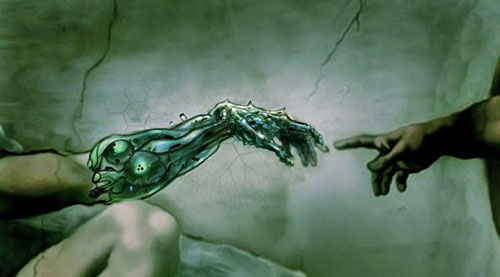

The idea of tracking one's eye movements for scientific purposes has existed for a long time, but it hasn't been until very recently that the technology to do so has become accessible and easy to use for more than highly specialized scientific studies. Before, one would need to lock their head into place with either specialized contacts with aluminum pointers or later beams of light pointed at their eyes which would reflect onto film and record the path taken. Eventually, cameras were used in conjunction with computers which would allow for better, real-time tracking, but even so these would require specialized systems. Electrodes have also been used, placing them around the user's eyes to measure the movement of the eye muscles, which is useful for measuring the movement of closed eyes as well, but this is even more difficult for household use.

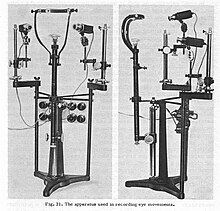



Yarbus eye tracker from the 1960s

### But why track eyes?

There are many reasons one might want to track somebody's eyes, varying from more [find the right word, similar to selfish] reasons like creating more efficient advertising by figuring out what draws people's eyes to more altruistic ones like assisting those with severe motor impairment by allowing them to interact with the world just by looking at a screen.

#### Personal Reason

The reason I was first drawn to the idea of eye tracking was thanks to a popular Twitch/YouTube creator Douglas Wreden (also known as DougDoug). Mr. Wreden started out as a relatively standard gaming content creator, but quickly distinguished himself from other similar channels using his background in computer science. Beginning with simple code which would allow his Twitch chat to input commands in a game, he slowly began to experiment with more and more new technologies, from more advanced chat integration to using ChatGPT and other AI tools in order to create characters which would appear on his streams. The first time I had ever seen eye tracking in use was in one of his streams where he utilized a Tobii eye tracking device to make a game harder by restarting whenever he looked at a certain part of the screen.

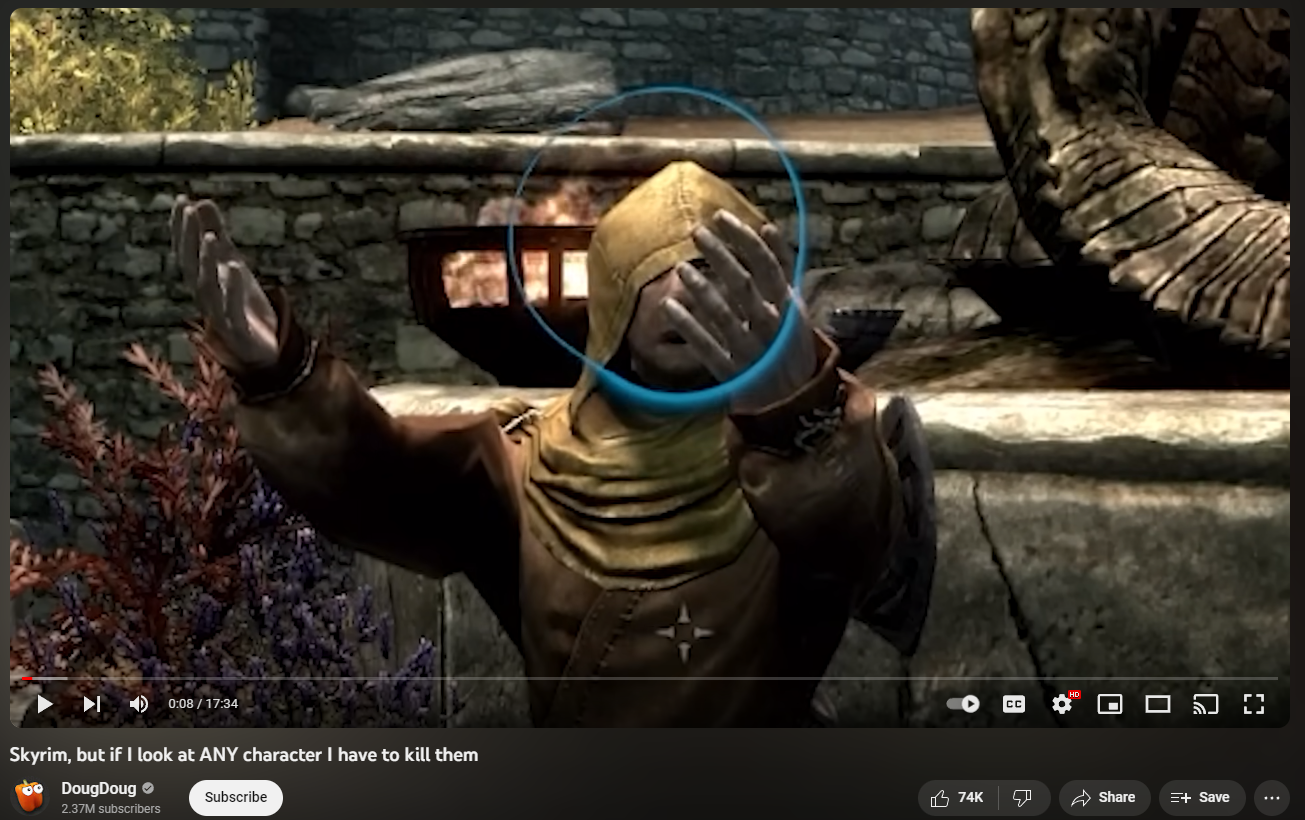

After hearing about this technology, I was intrigued, and looked into what it took. I was surprised that it required such specialized technology, but I didn't think much of it. However, when it came time to come up with an interesting topic for this final project, I immediately thought of finding a way to do eye tracking without this specialized technology.

### The Modern Technology


As previously discussed, there are many different methods of eye tracking, but the one I would like to focus on is referred to as remote eye tracking. This type of eye tracking does not require contact with the user, nor does it require head stabilization, which makes it the most accessible for most people.

Tobii is likely the most well-known eye tracking company at the time of writing. They have a wide variety of eye tracking products, software and hardware, including things like eye tracking systems built into gaming laptops, glasses for personal eye tracking in a multitude of situations, development tools for those looking to utilize Tobii eye tracking hardware in projects, and more. However, Tobii and other companies who have developed eye tracking systems for the most part have something in common -- specialized hardware is required even in remote systems, usually being one or more IR cameras used to better detect the user's pupils and head position/angle.

However, a new method of tracking one's head/eye position has entered the ring -- software-based tracking. While it is still a long way behind the accuracy of a dedicated hardware-based solution for now, with computers becoming more and more computationally capable especially in the realm of machine learning, it has the potential to be a much more cost-effective and accessible option.

## Machine Learning Based Eye Tracking

### An Example
This is an example of an existing OpenCV-based eye tracking implementation. It is much more simple than what I am going for, only being able to tell if the user is looking left, right, or center, but it is a good baseline and can be compared to my own results of what I was able to accomplish.

#### Setup

This is pip installing libraries which might not be included as well as setting up the camera to work with Google Colab.

In [1]:
try:
  import numpy as np
except:
  !pip install numpy
  import numpy as np
try:
  import cv2
except:
  !pip install opencv_python
  import cv2
try:
  import dlib
except:
  !pip install dlib
  import dlib

In [2]:
import sys
sys.path.insert(1, '/content/drive/MyDrive/FinalFinalProjects')

In [3]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [4]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [5]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [6]:
def take_photo(filename='photo.jpg', quality=1):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      //await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  return img

#### Running

This is currently only set up to work on Google Colab with the correct files from [this](https://github.com/antoinelame/GazeTracking) repository. This is just an example of a pre-existing model, not my own model, which can be found below.

In [86]:
"""
Demonstration of antoinelame's GazeTracking library.
"""
from IPython.display import clear_output

import cv2
from gaze_tracking import GazeTracking
from google.colab.patches import cv2_imshow

video_stream()
gaze = GazeTracking()
webcam = cv2.VideoCapture(video_stream())

while True:
    #clear_output()
    # We get a new frame from the webcam
    #_, frame = webcam.read()
    #frame = js_to_image(video_frame(label_html, bbox)["img"])
    frame = take_photo()
    clear_output()

    # We send this frame to GazeTracking to analyze it
    gaze.refresh(frame)

    frame = gaze.annotated_frame()
    text = ""

    if gaze.is_blinking():
        text = "Blinking"
    elif gaze.is_right():
        text = "Looking right"
    elif gaze.is_left():
        text = "Looking left"
    elif gaze.is_center():
        text = "Looking center"

    cv2.putText(frame, text, (90, 60), cv2.FONT_HERSHEY_DUPLEX, 1.6, (147, 58, 31), 2)

    left_pupil = gaze.pupil_left_coords()
    right_pupil = gaze.pupil_right_coords()
    cv2.putText(frame, "Left pupil:  " + str(left_pupil), (90, 130), cv2.FONT_HERSHEY_DUPLEX, 0.9, (147, 58, 31), 1)
    cv2.putText(frame, "Right pupil: " + str(right_pupil), (90, 165), cv2.FONT_HERSHEY_DUPLEX, 0.9, (147, 58, 31), 1)

    cv2_imshow(frame)
    time.sleep(1)

    if cv2.waitKey(1) == 27:
        break

webcam.release()
cv2.destroyAllWindows()

KeyboardInterrupt: ignored

### My Method

While not fully finished, here is my basic work on designing my own ML-based eye tracking.

#### Research

Before doing any research into the project, I came up with a basic idea of how my implementation would work. I had a feeling that I wouldn't be able to do face/eye detection from scratch using only the tools we had from class with the time I had. Instead, my plan was to use an existing face/eye/pupil detection model to generate an input for my eye tracking model.

For data, I would create my own dataset by creating a program which would display a pixel on a screen and then take a webcam image of myself (or anybody I could get to participate) once a button is pressed confirming that I am looking at the pixel. That image and the pixel's x and y coordinates would be stored.

To train my model, I would run each captured image through the existing face/eye/pupil detection model, which would give features which my own model could use as inputs, with the x and y coordinates of the pixel as outputs. I would then train my model using this data, testing out different models and different hyperparameters to find which one would be most consistent.

With the time and resources I had, I was unable to create a dataset of my own in time to get a working model. However, I have supplemental research on similar projects to discuss their pros and cons, and how I might modify my project in order to make it better.

##### GazeCapture

The first thing I found when looking for datasets similar to what I was planning on doing was [GazeCapture](https://github.com/CSAILVision/GazeCapture.git) \(their paper can be found [here](https://gazecapture.csail.mit.edu/index.php)). This is one of the few projects I was able to find where they were doing almost exactly what I was looking for -- not just detecting the direction of a person's gaze, but rather looking at where on a screen a person was looking. They created the GazeCapture dataset by uploading an application to the iOS app store which would display pulsating red dots on screen at various positions and record the user's face cam as they look at the dots. There are other parts of the application, such as making the user press left or right on the screen depending on if there is an L or an R displayed in the dot, in order to make sure the user is engaged, but otherwise the idea is almost exactly what I was thinking of in order to collect data.

Using this data, they trained a Convolutional Neural Network, which they named iTracker, for gaze prediction. iTracker did not use any pre-existing face or eye detection, and was able to outperform similar approaches by a significant margin, according to the paper. However, the iTracker model was too complex to run in real-time due to the size of the inputs.

The following is the iTracker Pytorch model. You can see the combinations of steps they have in their model for both face and eyes in order to track the eyes.

In [ ]:
import argparse
import os
import shutil
import time, math
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import torch.utils.model_zoo as model_zoo
from torch.autograd.variable import Variable

'''
Pytorch model for the iTracker.

Author: Petr Kellnhofer ( pkel_lnho (at) gmai_l.com // remove underscores and spaces), 2018.

Website: http://gazecapture.csail.mit.edu/

Cite:

Eye Tracking for Everyone
K.Krafka*, A. Khosla*, P. Kellnhofer, H. Kannan, S. Bhandarkar, W. Matusik and A. Torralba
IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2016

@inproceedings{cvpr2016_gazecapture,
Author = {Kyle Krafka and Aditya Khosla and Petr Kellnhofer and Harini Kannan and Suchendra Bhandarkar and Wojciech Matusik and Antonio Torralba},
Title = {Eye Tracking for Everyone},
Year = {2016},
Booktitle = {IEEE Conference on Computer Vision and Pattern Recognition (CVPR)}
}

'''


class ItrackerImageModel(nn.Module):
    # Used for both eyes (with shared weights) and the face (with unqiue weights)
    def __init__(self):
        super(ItrackerImageModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.CrossMapLRN2d(size=5, alpha=0.0001, beta=0.75, k=1.0),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2, groups=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.CrossMapLRN2d(size=5, alpha=0.0001, beta=0.75, k=1.0),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 64, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),

        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

class FaceImageModel(nn.Module):

    def __init__(self):
        super(FaceImageModel, self).__init__()
        self.conv = ItrackerImageModel()
        self.fc = nn.Sequential(
            nn.Linear(12*12*64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

class FaceGridModel(nn.Module):
    # Model for the face grid pathway
    def __init__(self, gridSize = 25):
        super(FaceGridModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(gridSize * gridSize, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x



class ITrackerModel(nn.Module):


    def __init__(self):
        super(ITrackerModel, self).__init__()
        self.eyeModel = ItrackerImageModel()
        self.faceModel = FaceImageModel()
        self.gridModel = FaceGridModel()
        # Joining both eyes
        self.eyesFC = nn.Sequential(
            nn.Linear(2*12*12*64, 128),
            nn.ReLU(inplace=True),
            )
        # Joining everything
        self.fc = nn.Sequential(
            nn.Linear(128+64+128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 2),
            )

    def forward(self, faces, eyesLeft, eyesRight, faceGrids):
        # Eye nets
        xEyeL = self.eyeModel(eyesLeft)
        xEyeR = self.eyeModel(eyesRight)
        # Cat and FC
        xEyes = torch.cat((xEyeL, xEyeR), 1)
        xEyes = self.eyesFC(xEyes)

        # Face net
        xFace = self.faceModel(faces)
        xGrid = self.gridModel(faceGrids)

        # Cat all
        x = torch.cat((xEyes, xFace, xGrid), 1)
        x = self.fc(x)

        return x

##### Convolutional Neural Network-Based Methods for Eye Gaze Estimation: A Survey

One of the other sources I found which discussed eye tracking in a more broad sense is [Convolutional Neural Network-Based Methods for Eye Gaze Estimation: A Survey](https://ieeexplore.ieee.org/abstract/document/9153754) which is a survey of different deep learning-based gaze estimation techniques, focusing on convolutional nerual networks, as well as other methods. The paper discusses 2D and 3D approaches to eye tracking, and was focused more on explaining the general types of eye tracking.

#### Actual Code

##### A modified version of an existing eye, face, and pupil detection system using OpenCV

This is a modified version of [this](https://github.com/stepacool/Eye-Tracker/tree/No_GUI) repository by stepacool, which is a very basic pupil detection implementation using OpenCV.


Note: run the Setup in the Machine Learning Based Eye Tracking first

Found an eye...


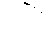

Found an eye...


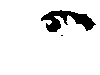

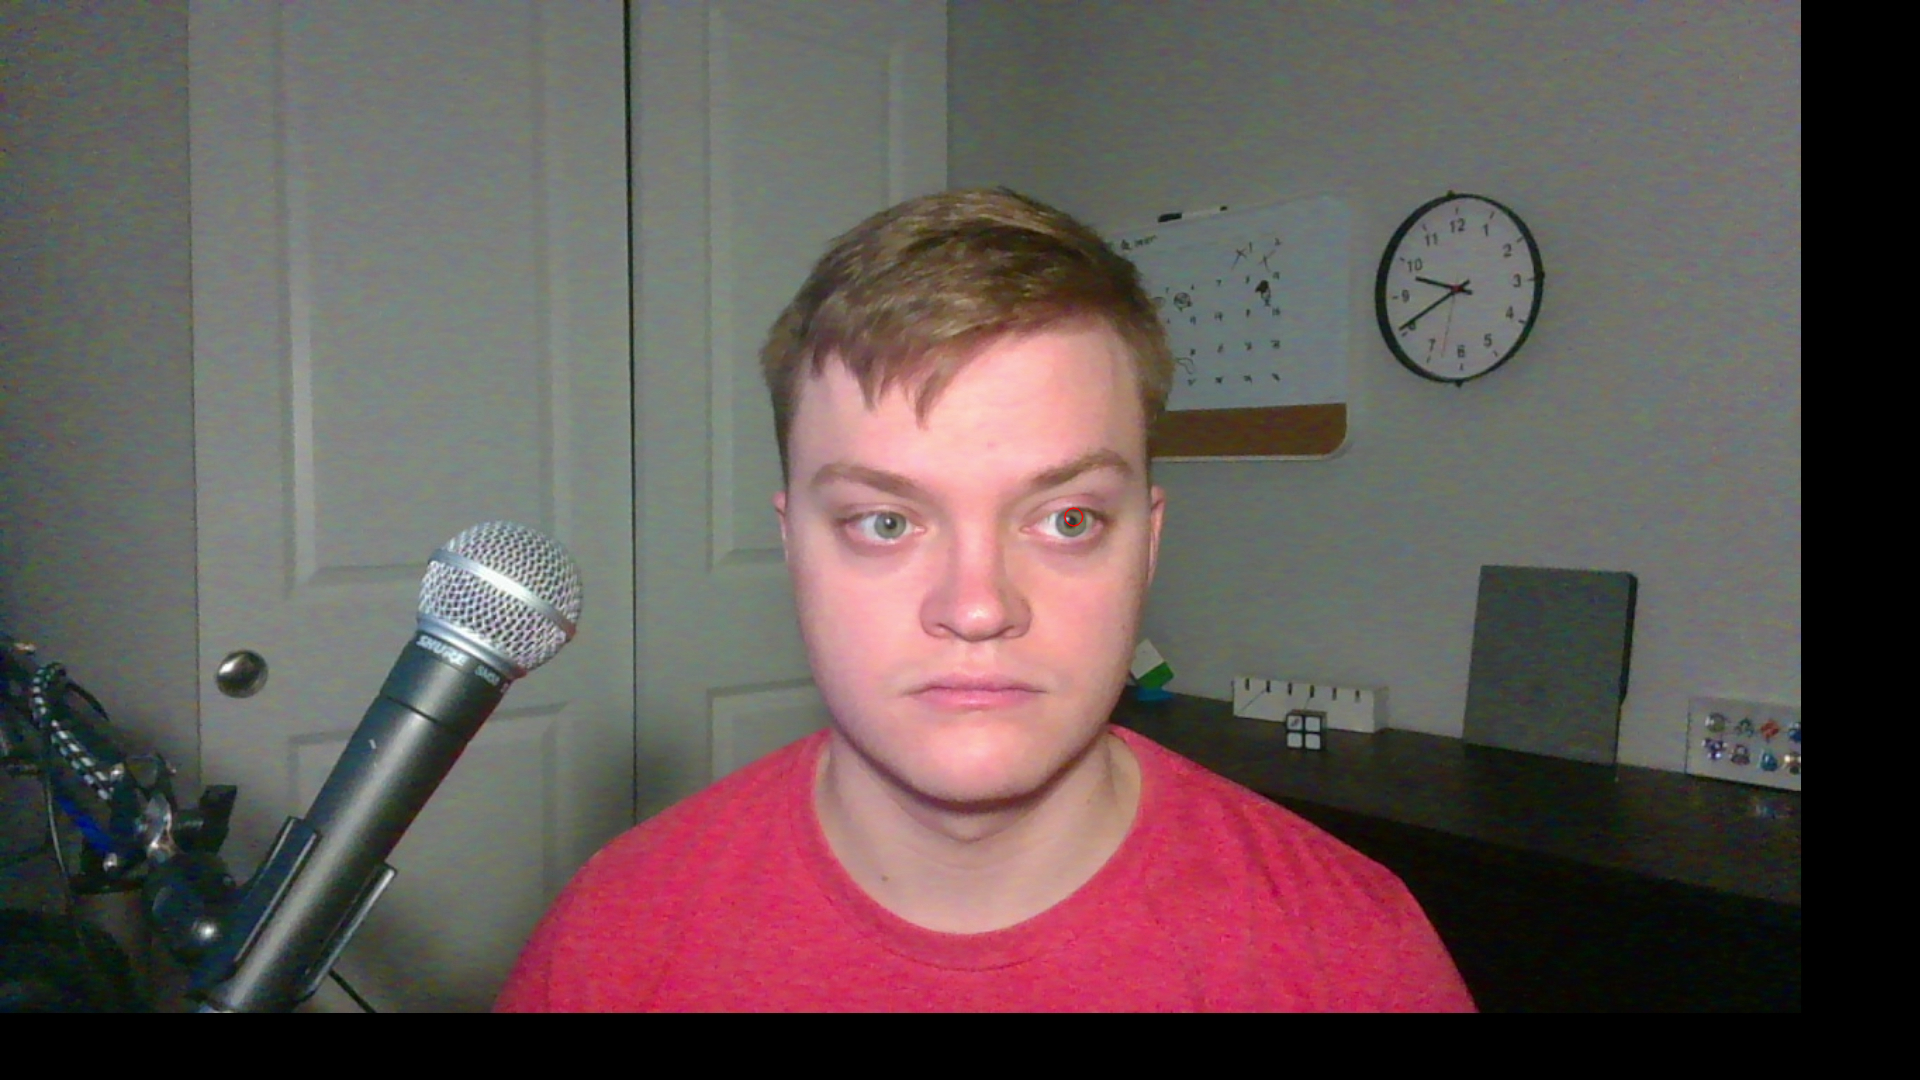

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [15]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import clear_output


# init part
# May need to change the following 2 lines to the correct path, if you don't have the files check the repository
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/FinalFinalProjects/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/FinalFinalProjects/haarcascade_eye.xml')
detector_params = cv2.SimpleBlobDetector_Params()
detector_params.filterByArea = True
detector_params.maxArea = 1500
detector = cv2.SimpleBlobDetector_create(detector_params)


def detect_faces(img, cascade):
    gray_frame = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_rect = []
    coords = cascade.detectMultiScale(gray_frame, 1.3, 5)
    if len(coords) > 1:
        biggest = (0, 0, 0, 0)
        for i in coords:
            if i[3] > biggest[3]:
                biggest = i
        biggest = np.array([i], np.int32)
    elif len(coords) == 1:
        biggest = coords
    else:
        return None, face_rect
    for (x, y, w, h) in biggest:
        frame = img[y:y + h, x:x + w]
        face_rect = [x, y, w, h]
    return frame, face_rect


def detect_eyes(img, cascade):
    left_rect = [0,0,0,0]
    right_rect = [0,0,0,0]
    gray_frame = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eyes = cascade.detectMultiScale(gray_frame, 1.3, 5)  # detect eyes
    width = np.size(img, 1)  # get face frame width
    height = np.size(img, 0)  # get face frame height
    left_eye = None
    right_eye = None
    for (x, y, w, h) in eyes:
        if y > height / 2:
            pass
        eyecenter = x + w / 2  # get the eye center
        if eyecenter < width * 0.5:
            left_eye = img[y:y + h, x:x + w]
            left_rect = [x,y,w,h]
        else:
            right_eye = img[y:y + h, x:x + w]
            right_rect = [x,y,w,h]
    return (left_eye, right_eye), left_rect, right_rect


def cut_eyebrows(img):
    height, width = img.shape[:2]
    eyebrow_h = int(height / 4)
    img = img[eyebrow_h:height, 0:width]  # cut eyebrows out (15 px)

    return img


def blob_process(img, threshold, detector):
    gray_frame = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #cv2_imshow(gray_frame)
    _, img = cv2.threshold(gray_frame, threshold, 255, cv2.THRESH_BINARY)
    cv2_imshow(img)
    img = cv2.erode(img, None, iterations=2)
    img = cv2.dilate(img, None, iterations=4)
    img = cv2.medianBlur(img, 5)
    #cv2_imshow(img)
    keypoints = detector.detect(img)
    #print(keypoints)
    return keypoints


def nothing(x):
    pass


def main():
    #cap = cv2.VideoCapture(1) # Uncomment if not google colab
    #cv2.namedWindow('image') # Uncomment if not google colab
    #cv2.createTrackbar('threshold', 'image', 0, 255, nothing) # Uncomment if not google colab
    while True:
        #_, frame = cap.read() # Uncomment if not google colab
        frame = take_photo() # Uncomment if using google colab
        face_frame, face_pos = detect_faces(frame, face_cascade)
        clear_output()
        if face_frame is not None:
            #cv2_imshow(face_frame)
            eyes, l_pos, r_pos = detect_eyes(face_frame, eye_cascade)
            for eye in eyes:
                print("Found an eye...")
                if eye is not None:
                    #threshold = r = cv2.getTrackbarPos('threshold', 'image')
                    # Modify the threshold manually for now, could also iterate through thresholds if no keypoints are found
                    threshold = 105
                    eye = cut_eyebrows(eye)
                    keypoints = blob_process(eye, threshold, detector)
                    eye = cv2.drawKeypoints(eye, keypoints, eye, (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
                    #cv2_imshow(eye)
                else:
                    print("No eyes")
        else:
            print("No face")
        cv2_imshow(frame)
        time.sleep(0.1)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    #cap.release() # Uncomment if not google colab
    #cv2.destroyAllWindows() # Uncomment if not google colab

if __name__ == "__main__":
    main()


The above code can be used to pull the face, pupil, and eye positions from the image. This would be run alongside another full-screen application, which displays a pixel on screen, where the user presses space once they are looking at the pixel, OR where the pixel slowly moves across the screen and the user must follow it with their gaze. Another way to do this, since there is both an x and a y output, would be to display a vertical or horizontal line of pixels, and have the user look from bottom to top or left to right along the group of pixels, and then record video of it. This way, two separate models could be created, one for the x position and one for the y position. The inputs and outputs of the dataset would be something along the lines of:

x: facex, facey, facew, faceh, leyex, leyey, leyew, leyeh, reyex, reyey, reyew, reyeh, lpupilx, lpupily

y: pixelx, pixely

It is important to have face position and size, as well as eye positions and size along with pupil positions in order for the model to have features relating implicitly to where the user's head is in 3d space and how it is rotated.

##### A model to detect looking left and right on the screen

The idea here is to create a dataset by grabbing images of the user looking left and right, then to use neural network boosting to train a 2 class dataset with training and validation. At the end, I have a way of testing the model in real time. This is very finnicky, but I was able to get decent results even with only 20 datapoints, especially considering how little I had tuned the pupil threshold and the hyperparameters of the model.

Of course, this is still pretty much the same as the first example model I provided, and it is a multiclass model when ideally it should be either one multi-output regression model or two single-output regression models, however I plan on improving this in the future.

Here is a modified version of the code to get positions of face/eyes, which creates a dataset

In [16]:
num_its_per_direction = 20 # How many times you look left/right
brightness_threshold = 100 # Threshold for pupil detection, change this if you get bad results

In [25]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
import sys


def blob_process(img, threshold, detector):
    gray_frame = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #cv2_imshow(gray_frame)
    _, img = cv2.threshold(gray_frame, threshold, 255, cv2.THRESH_BINARY)
    #cv2_imshow(img)
    img = cv2.erode(img, None, iterations=2)
    img = cv2.dilate(img, None, iterations=4)
    img = cv2.medianBlur(img, 5)
    #cv2_imshow(img)
    keypoints = detector.detect(img)
    #print(keypoints)
    return keypoints

def collect_data(num_its):
    #cap = cv2.VideoCapture(1) # Uncomment if not google colab
    #cv2.namedWindow('image') # Uncomment if not google colab
    #cv2.createTrackbar('threshold', 'image', 0, 255, nothing) # Uncomment if not google colab
    y = []
    x = []
    for i in range(0,num_its*2):
        print(i)
        l_pos = []
        r_pos = []
        pupil_l = []
        pupil_r = []
        if(i == 0):
            print("Look left")
            y.append(1)
            time.sleep(5)
        elif(i < num_its):
            print("Look left")
            y.append(1)
            time.sleep(0.1)
        elif(i == num_its):
            print("look right")
            y.append(-1)
            time.sleep(5)
        else:
            print("Look right")
            y.append(-1)
            time.sleep(0.1)
        frame = take_photo() # Uncomment if using google colab
        #_, frame = cap.read() # Uncomment if not google colab
        #clear_output()
        face_frame, face_pos = detect_faces(frame, face_cascade)
        if face_frame is not None:
            #cv2_imshow(face_frame)
            eyes, l_pos, r_pos = detect_eyes(face_frame, eye_cascade)
            j = 0
            for eye in eyes:
                j = j + 1;
                print("Found an eye...")
                if eye is not None:
                    #threshold = r = cv2.getTrackbarPos('threshold', 'image')
                    # Modify the threshold manually for now, could also iterate through thresholds if no keypoints are found
                    retry = True
                    threshold = brightness_threshold - 1
                    eye = cut_eyebrows(eye)
                    while retry:
                        threshold = threshold + 1
                        keypoints = blob_process(eye, threshold, detector)
                        if(j == 1):
                            if(len(keypoints) > 0):
                                pupil_l.append(keypoints[0].pt)
                                retry = False
                            else:
                                if(threshold >= 255):
                                    print("No pupil")
                                    pupil_l.append((0.,0))
                                    retry = False
                        elif(j == 2):
                            if(len(keypoints) > 0):
                                pupil_r.append(keypoints[0].pt)
                            else:
                                if(threshold >= 255):
                                    print("No pupil")
                                    pupil_r.append((0.,0))
                                    retry = False
                    eye = cv2.drawKeypoints(eye, keypoints, eye, (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
                    #cv2_imshow(eye)
                else:
                    print("No eye")
                    if(j == 1):
                        pupil_l.append((0.,0))
                    elif(j == 2):
                        pupil_r.append((0.,0))
            x.append([face_pos[0],face_pos[1],face_pos[2],face_pos[3],l_pos[0],l_pos[1],l_pos[2],l_pos[3],r_pos[0],r_pos[1],r_pos[2],r_pos[3],pupil_l[0][0],pupil_l[0][1],pupil_r[0][0],pupil_r[0][1]])
        else:
            print("No face")
        cv2_imshow(frame)
        time.sleep(2)
        clear_output()
        print("ready!")
        time.sleep(1)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    return x,y
    #cap.release() # Uncomment if not google colab
    #cv2.destroyAllWindows() # Uncomment if not google colab

In [26]:
x1, y1 = collect_data(num_its_per_direction)
print(x1)
print(y1)

ready!
[[706, 367, 478, 478, 110, 157, 90, 90, 293, 150, 98, 98, 52.09468078613281, 20.92347526550293, 83.6467056274414, 19.68463134765625], [763, 413, 401, 401, 51, 98, 108, 108, 245, 101, 105, 105, 15.442307472229004, 22.423076629638672, 0.0, 0], [640, 397, 452, 452, 81, 126, 110, 110, 282, 118, 111, 111, 69.55773162841797, 30.318758010864258, 0.0, 0], [670, 405, 449, 449, 78, 121, 104, 104, 280, 119, 104, 104, 65.49951171875, 25.314651489257812, 68.93103790283203, 50.59770202636719], [667, 370, 445, 445, 91, 131, 86, 86, 277, 124, 101, 101, 53.11458206176758, 21.074073791503906, 0.0, 0], [693, 370, 446, 446, 81, 122, 101, 101, 275, 126, 101, 101, 62.26422882080078, 25.233062744140625, 0.0, 0], [779, 379, 388, 388, 64, 91, 98, 98, 239, 95, 97, 97, 11.442307472229004, 22.423076629638672, 14.884848594665527, 42.70302963256836], [668, 367, 473, 473, 74, 121, 121, 121, 284, 110, 130, 130, 75.51020050048828, 35.418365478515625, 84.78974151611328, 63.517948150634766], [682, 373, 458, 458, 

In [28]:
# import basic librariees and autograd wrapped numpy
from sklearn.datasets import fetch_openml
import sys
sys.path.append('../')
import autograd.numpy as np2
import matplotlib.pyplot as plt
from autograd import grad
from autograd import hessian
from autograd import value_and_grad
from autograd.misc.flatten import flatten_func
import pandas as pd


# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
#from matplotlib import rcParams
#rcParams['figure.autolayout'] = True

# datapath to data
datapath = '/content/drive/MyDrive/Colab Notebooks/mlrefined_datasets/nonlinear_superlearn_datasets/'


from numba import njit, prange

In [29]:
x4old = np2.array(x1).T
y4new = np2.array(y1)[np2.newaxis,:]
mean_values4 = np2.nanmean(x4old, axis=1, keepdims=True)
std_values4 = np2.nanstd(x4old, axis=1, keepdims=True)
#x4new = (x4old-mean_values4)/std_values4
x4new = x4old

print(np2.shape(x4new))
print(np2.shape(y4new))

(16, 40)
(1, 40)


In [30]:
# So that I can save the data for demonstration purposes
# Keep this to 0 unless you plan on testing it
save = 1

In [31]:
if(save == 1):
  x4 = x4new
  y4 = y4new
  with open('x4.npy', 'wb') as f:
    np.save(f, x4new)
  with open('y4.npy', 'wb') as f:
    np.save(f, y4new)
else:
  with open('x4.npy', 'rb') as f:
    x4 = np.load(f)
  with open('y4.npy', 'rb') as f:
    y4 = np.load(f)


In [32]:
# newtons method function - inputs: g (input function), max_its (maximum number of iterations), w (initialization)
def newtons_method(g,max_its,w,**kwargs):
    # flatten input funciton, in case it takes in matrices of weights
    flat_g, unflatten, w = flatten_func(g, w)

    # compute the gradient / hessian functions of our input function -
    # note these are themselves functions.  In particular the gradient -
    # - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(flat_g)
    hess = hessian(flat_g)
     # set numericxal stability parameter / regularization parameter
    epsilon = 10**(-7)
    if 'epsilon' in kwargs:
        epsilon = kwargs['epsilon']

    # run the newtons method loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    for k in range(max_its):
        # evaluate the gradient, store current weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(unflatten(w))
        cost_history.append(cost_eval)

        # evaluate the hessian
        hess_eval = hess(w)

        # reshape for numpy linalg functionality
        hess_eval.shape = (int((np2.size(hess_eval))**(0.5)),int((np2.size(hess_eval))**(0.5)))

        # solve second order system system for weight update
        w = w - np2.dot(np2.linalg.pinv(hess_eval + epsilon*np2.eye(np.size(w))),grad_eval)

    # collect final weights
    weight_history.append(unflatten(w))
    # compute final cost function value via g itself (since we aren't computing
    # the gradient at the final step we don't get the final cost function value
    # via the Automatic Differentiatoor)
    cost_history.append(flat_g(w))
    return cost_history,weight_history

In [45]:
training_indices4 = np2.sort(np2.random.choice(np2.shape(x4)[1], int(2*np2.shape(x4)[1]/3), replace=False))
validation_indices4 = np2.delete(np2.arange(np.shape(x4)[1]), training_indices4)
x4train = x4.T[training_indices4].T
x4valid = x4.T[validation_indices4].T
y4train = y4[0][training_indices4]
y4valid = y4[0][validation_indices4]
print(x4.shape)
print(x4train.shape)
print(x4valid.shape)

(16, 40)
(16, 26)
(16, 14)


In [34]:
def initial_model4(x,w):
  return (w*np2.ones((1,x.shape[1])))

In [35]:
def softmax4_train(w,model):
  cost = np2.sum(np2.log(1 + np2.exp(-y4train*model(x4train,w))))
  a = cost/float(np2.size(y4train))
  return a

In [36]:
def softmax4_validate(w,model):
  cost = np2.sum(np2.log(1 + np2.exp(-y4valid*model(x4valid,w))))
  a = cost/float(np2.size(y4valid))
  return a

In [37]:
def softmax4_overall(w,model):
  cost = np2.sum(np2.log(1 + np2.exp(-y4*model(x4,w))))
  a = cost/float(np2.size(y4))
  return a

In [38]:
def feature_transforms4(x,w):
    # calculate feature transform

    # No transform
    f = x
    return f

In [39]:
def perceptron4(x, w):
        # compute inner product with current layer weights
        f = feature_transforms4(x,w)
        a = w[0][0] + np2.dot(f.T, w[0][1:])
        # output of layer activation
        a = np2.maximum(0,a).T
        # final linear combo
        a = w[1][0] + np2.dot(a.T,w[1][1:])
        return a.T

In [40]:
def misclass_calc(model, x, true_labels, threshold=0):
    # Get model predictions
    predicted_probs = model(x)
    # Convert predicted probabilities to binary predictions based on the threshold
    binary_predictions = (predicted_probs >= threshold).astype(int)
    binary_predictions = np2.array([-1 if x == 0 else x for x in binary_predictions[0]])
    # Count misclassifications
    misclassifications = np2.sum(binary_predictions != true_labels)
    return misclassifications


In [46]:
def neural_net_boosting_learner(num_steps, max_its, scale):
  step_array = np.arange(1,num_steps)
  best_units = []
  model_history = []
  training_cost_history = []
  validation_cost_history = []
  combined_cost_history = []
  training_misclassification_history = []
  validation_misclassification_history = []
  combined_misclassification_history = []
  w_best_history = []
  model_0 = initial_model4;
  unfinished = True;
  s_factor = 1.0
  while unfinished:
    scale_temp = round(scale*s_factor,4);
    print("Step: ", 0)
    print("Scale: ", scale_temp)
    w = scale_temp*np2.random.randn(1)
    try:
      cost_hist, weight_hist = newtons_method(lambda w : softmax4_train(w, model_0), max_its, w)
      unfinished = False
    except np2.linalg.LinAlgError:
      print("Did not converge! Decreasing scale")
      s_factor = s_factor - 0.1
  ind = np2.argmin(cost_hist)
  w_best = weight_hist[ind]
  w_best_history.append(w_best)
  model = lambda x,w=w_best : model_0(x,w)
  best_units.append(model)
  model_history.append(model)
  training_cost_history.append(softmax4_train(w_best,model))
  validation_cost_history.append(softmax4_validate(w_best,model))
  combined_cost_history.append(softmax4_overall(w_best,model))
  training_misclassification_history.append(misclass_calc(model, x4train, y4train))
  validation_misclassification_history.append(misclass_calc(model, x4valid, y4valid))
  combined_misclassification_history.append(misclass_calc(model, x4, y4))
  for j in step_array:
    next_unit = lambda x,w: perceptron4(x,w)
    current_model = lambda x,w: model(x) + next_unit(x,w)
    unfinished = True;
    s_factor = 1.0
    while unfinished:
      scale_temp = round(scale*s_factor,4);
      print("Step: ", j)
      print("Scale: ", scale_temp)
      w = [scale_temp*np2.random.randn(x4train.shape[0] + 1,1), scale_temp*np2.random.randn(2,1), scale_temp*np.random.randn(6,1)]
      try:
        cost_hist, weight_hist = newtons_method(lambda w : softmax4_train(w, current_model), max_its, w)
        unfinished = False
      except np2.linalg.LinAlgError:
        print("Did not converge! Decreasing scale")
        s_factor = s_factor * 0.9
    ind = np2.argmin(cost_hist)
    w_best = weight_hist[ind]
    w_best_history.append(w_best)
    best_perceptron = lambda x,w=w_best: next_unit(x,w)
    best_units.append(best_perceptron)
    next_model = lambda x,w=w_best : current_model(x,w)
    model_history.append(next_model)
    training_cost_history.append(softmax4_train(w_best,next_model))
    validation_cost_history.append(softmax4_validate(w_best,next_model))
    combined_cost_history.append(softmax4_overall(w_best,next_model))
    training_misclassification_history.append(misclass_calc(next_model, x4train, y4train))
    validation_misclassification_history.append(misclass_calc(next_model, x4valid, y4valid))
    combined_misclassification_history.append(misclass_calc(next_model, x4, y4))
    model = lambda x,units=best_units: np2.sum([v(x) for v in units],axis=0)
    print("Misclassifications: ", combined_misclassification_history[-1])
  return w_best_history, best_units, model_history, training_cost_history, validation_cost_history, combined_cost_history, training_misclassification_history, validation_misclassification_history, combined_misclassification_history

Step:  0
Scale:  0.5
Step:  1
Scale:  0.5
Misclassifications:  20
Step:  2
Scale:  0.5
Misclassifications:  20
Step:  3
Scale:  0.5
Misclassifications:  20
Step:  4
Scale:  0.5
Misclassifications:  20
Step:  5
Scale:  0.5
Did not converge! Decreasing scale
Step:  5
Scale:  0.45
Misclassifications:  20
Step:  6
Scale:  0.5
Did not converge! Decreasing scale
Step:  6
Scale:  0.45
Did not converge! Decreasing scale
Step:  6
Scale:  0.405
Misclassifications:  20
Step:  7
Scale:  0.5
Misclassifications:  20
Step:  8
Scale:  0.5
Did not converge! Decreasing scale
Step:  8
Scale:  0.45
Misclassifications:  20
Step:  9
Scale:  0.5
Did not converge! Decreasing scale
Step:  9
Scale:  0.45
Did not converge! Decreasing scale
Step:  9
Scale:  0.405
Misclassifications:  20
Step:  10
Scale:  0.5
Did not converge! Decreasing scale
Step:  10
Scale:  0.45
Misclassifications:  20
Step:  11
Scale:  0.5
Misclassifications:  20
Step:  12
Scale:  0.5
Did not converge! Decreasing scale
Step:  12
Scale:  0.45


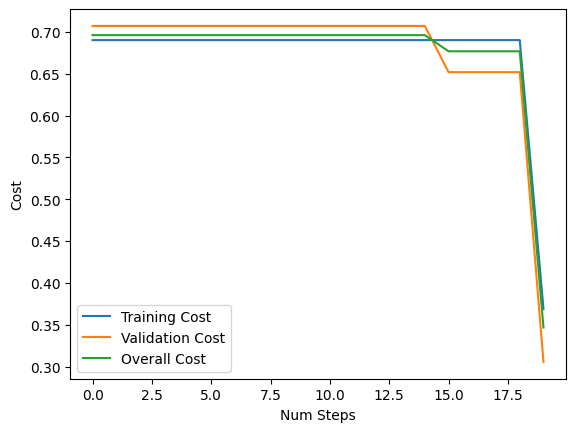

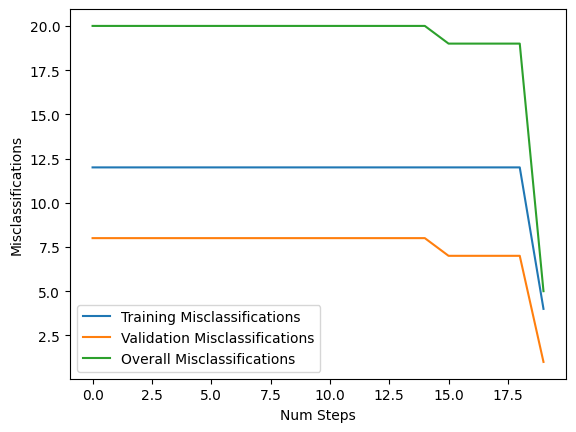

In [48]:
num_steps4 = 20
max_its4 = 60
scale4 = .5
w_best_hist4, best_units4, model_history4, tcost_hist4, vcost_hist4, ccost_hist4, tmisclass_hist4, vmisclass_hist4, cmisclass_hist4 = neural_net_boosting_learner(num_steps4,max_its4,scale4)
true_steps = np.arange(0, np.array(tcost_hist4).shape[0])
plt.plot(true_steps, tcost_hist4, label="Training Cost")
plt.plot(true_steps, vcost_hist4, label="Validation Cost")
plt.plot(true_steps, ccost_hist4, label="Overall Cost")
plt.xlabel('Num Steps')
plt.ylabel('Cost')
plt.legend()
plt.show()
plt.plot(true_steps, tmisclass_hist4, label="Training Misclassifications")
plt.plot(true_steps, vmisclass_hist4, label="Validation Misclassifications")
plt.plot(true_steps, cmisclass_hist4, label="Overall Misclassifications")
plt.xlabel('Num Steps')
plt.ylabel('Misclassifications')
plt.legend()
plt.show()

In [49]:
best_ind4 = np.argmin(cmisclass_hist4)
best_model4 = model_history4[best_ind4]
w4f = w_best_hist4[best_ind4]
print("Misclassifications: ", misclass_calc(best_model4,x4,y4))
#print("Predictions: ", best_model4(x4,))

Misclassifications:  5


In [50]:
def test_model(num_its=1):
    #cap = cv2.VideoCapture(1) # Uncomment if not google colab
    #cv2.namedWindow('image') # Uncomment if not google colab
    #cv2.createTrackbar('threshold', 'image', 0, 255, nothing) # Uncomment if not google colab
    x = []
    for i in range(0,num_its):
        print(i)
        l_pos = []
        r_pos = []
        pupil_l = []
        pupil_r = []
        clear_output()
        #_, frame = cap.read() # Uncomment if not google colab
        frame = take_photo() # Uncomment if using google colab
        face_frame, face_pos = detect_faces(frame, face_cascade)
        if face_frame is not None:
            #cv2_imshow(face_frame)
            eyes, l_pos, r_pos = detect_eyes(face_frame, eye_cascade)
            j = 0
            for eye in eyes:
                j = j + 1;
                print("Found an eye...")
                if eye is not None:
                    #threshold = r = cv2.getTrackbarPos('threshold', 'image')
                    # Modify the threshold manually for now, could also iterate through thresholds if no keypoints are found
                    threshold = brightness_threshold
                    eye = cut_eyebrows(eye)
                    keypoints = blob_process(eye, threshold, detector)
                    if(j == 1):
                        if(len(keypoints) > 0):
                            pupil_l.append(keypoints[0].pt)
                        else:
                            pupil_l.append((0.,0))
                    elif(j == 2):
                        if(len(keypoints) > 0):
                            pupil_r.append(keypoints[0].pt)
                        else:
                            pupil_r.append((0.,0))
                    eye = cv2.drawKeypoints(eye, keypoints, eye, (0, 0, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
                    #cv2_imshow(eye)
                else:
                    print("No eye")
                    if(j == 1):
                        pupil_l.append((0.,0))
                    elif(j == 2):
                        pupil_r.append((0.,0))
            x.append([face_pos[0],face_pos[1],face_pos[2],face_pos[3],l_pos[0],l_pos[1],l_pos[2],l_pos[3],r_pos[0],r_pos[1],r_pos[2],r_pos[3],pupil_l[0][0],pupil_l[0][1],pupil_r[0][0],pupil_r[0][1]])
        else:
            print("No face")
        cv2_imshow(frame)
        #print(((np2.array(x)).T).shape)
        prediction = best_model4(np2.array(x[i])[np2.newaxis,:].T,w4f)
        #print(prediction)
        if(prediction[0][0] > 0):
            print("Looking Left")
        else:
            print("Looking Right")
        #print(prediction[0][0])
        time.sleep(5)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    #cap.release() # Uncomment if not google colab
    #cv2.destroyAllWindows() # Uncomment if not google colab

<IPython.core.display.Javascript object>

Found an eye...
Found an eye...


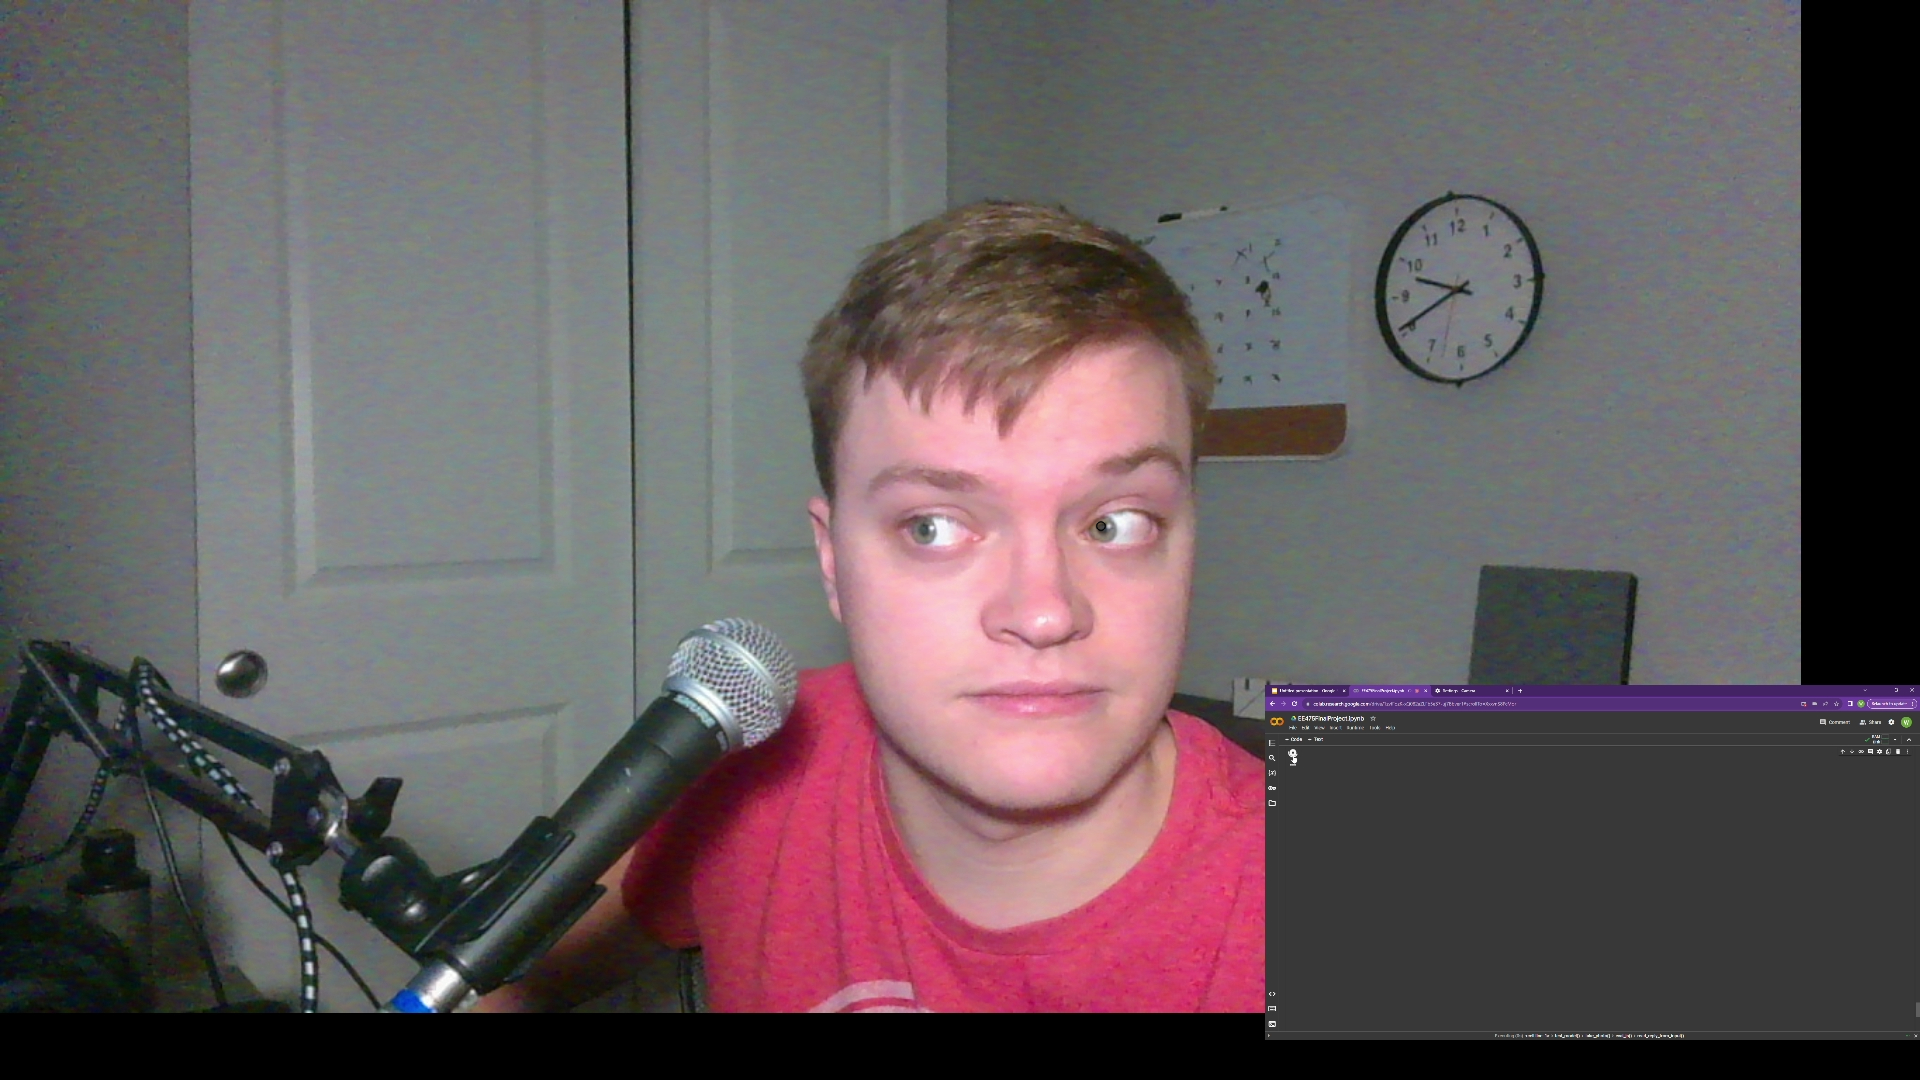

Looking Right


In [57]:
test_model()

#### Analysis and Future Work

The results of my simple left-right gaze detector using neural network boosting with softmax ended up being much more successful than I thought it would be going in.

On my first attempt, with a sample size of 20 admittedly rough input datapoints, I was able to get zero misclassifications on the training and validation sets. Given a bit more time and a local Python environment running on a decent computer and a larger, more robust dataset, I believe it would be more than possible to take this project and iterate upon it to get a decently reliable gaze tracker capable of estimating where on a screen the user is looking.

# Sources

Antoinelame Gaze Tracking: https://github.com/antoinelame/GazeTracking

Convolutional Neural Network-Based Methods for Eye Gaze Estimation: A Survey: https://ieeexplore.ieee.org/abstract/document/9153754

DougDoug: https://www.youtube.com/watch?v=6cI_D2dfw24

Eye Tracking for Everyone: https://gazecapture.csail.mit.edu/index.php

Tracking your eyes with Python: https://medium.com/@stepanfilonov/tracking-your-eyes-with-python-3952e66194a6

Wikipedia: https://en.wikipedia.org/wiki/Eye_tracking